# Reducing maintenance cost through predictive techniques:
###### Subhadeep Roy

### Business Problem:

##### 1. What is the business? 3D Technologies
##### 2. What is the problem? Scheduled maintenance for large number of devices are expensive and time consuming. Even so, any device can have sudden failures.
##### 3. How can we help? We can analyse any IoT data and build predictive model that can identify prospective device failures.
##### 4. What resources do we have? Telemetric readings from various devices that were captured over a period of time can be modelled to detect failures.
##### 5. What are the benefits? Predictive maintenance techniques are designed to help determine the condition of in-service equipment in order to predict when maintenance should be performed. This approach promises cost savings over routine or time-based preventive maintenance, because tasks are performed only when warranted.
##### 6. What are the considerations? Since we have to predict device failures which will most likely be minority classes, we have to try to reduce false-positives and false-negatives in order to avoid failures as well as undue maintenance. 

In [1]:
# Set Environment
setwd("C:\\Users\\SROY\\Documents\\CodeBase\\Datasets\\aws")
rm(list=ls())
seedVal = 17869
options(warn=-1)

In [ ]:
#Load Required libraries
library(parallel)
library(doMC)
library(DMwR)
library(zoo)
library(ROSE)
library(mlr)
library(dplyr)
library(pROC)
library(gridExtra)
library(caret)
library(xgboost)
library(ggplot2)
library(ggcorrplot)
library(lubridate)
library(corrplot)
library(reshape2)
library(dummies)
library(h2o)
theme_set(theme_classic())

In [3]:
#Import Data
df <- read.csv2('device_failure_aws.csv', sep = ',', header = TRUE)

In [4]:
# Check structure of data
str(df)
head(df)

'data.frame':	124494 obs. of  12 variables:
 $ date      : int  15001 15001 15001 15001 15001 15001 15001 15001 15001 15001 ...
 $ device    : Factor w/ 1168 levels "S1F01085","S1F013BB",..: 1 3 4 5 6 7 8 9 10 11 ...
 $ attribute1: int  215630672 61370680 173295968 79694024 135970480 68837488 227721632 141503600 8217840 116440096 ...
 $ attribute2: int  56 0 0 0 0 0 0 0 0 0 ...
 $ attribute3: int  0 3 0 0 0 0 0 0 1 323 ...
 $ attribute4: int  52 0 0 0 0 41 0 1 0 9 ...
 $ attribute5: int  6 6 12 6 15 6 8 19 14 9 ...
 $ attribute6: int  407438 403174 237394 410186 313173 413535 402525 494462 311869 407905 ...
 $ attribute7: int  0 0 0 0 0 0 0 16 0 0 ...
 $ attribute8: int  0 0 0 0 0 0 0 16 0 0 ...
 $ attribute9: int  7 0 0 0 3 1 0 3 0 164 ...
 $ failure   : int  0 0 0 0 0 0 0 0 0 0 ...


date,device,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,failure
15001,S1F01085,215630672,56,0,52,6,407438,0,0,7,0
15001,S1F0166B,61370680,0,3,0,6,403174,0,0,0,0
15001,S1F01E6Y,173295968,0,0,0,12,237394,0,0,0,0
15001,S1F01JE0,79694024,0,0,0,6,410186,0,0,0,0
15001,S1F01R2B,135970480,0,0,0,15,313173,0,0,3,0
15001,S1F01TD5,68837488,0,0,41,6,413535,0,0,1,0


### 1. Pre-process data
This step is for basic cosmetic changes which must be done prior to EDA and modelling.
The structure of the data looks fine and the datatypes are mostly appropriate except target variable device.
Initial thoughts just by looking at the data is the attribute recordings from telemetry devices may be sparse and couple of columns have large values.
The date column doesn't look right. The case mentions date in YYYY-MM-DD format and it looks nowhere close. We have to fix this first.
Also, failure is denoted as 1 and non failure as 0.

In [5]:
# Fix Datatype of failure
df$failure <- as.factor(df$failure)

# Date looks weird. Case study says YYYY-MM-DD format. Surly it's not in the same format.
#length(unique(df$date)) # 304 elements
# Need to check if there is a pattern
#length(grep('15*', unique(df$date))) # 304 elements

# Looks like the year is 2015 and the rest are the days. Fix it using lubridate.
df$date <- substr(df$date, start = 3, stop = 5)
df$date <- as_date(as.integer(df$date), origin = "2014-12-31")

# Create extra date value columns
df$wday <- lubridate::wday(df$date)
df$week <- lubridate::week(df$date)
df$month <- lubridate::month(df$date)
df <- df %>% select(date, wday, week, month, device, starts_with('att'), failure)

# Convert them into factors
df <- df %>% mutate_at(vars(wday, week, month), funs(factor(.)))
head(df)

date,wday,week,month,device,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,failure
2015-01-01,5,1,1,S1F01085,215630672,56,0,52,6,407438,0,0,7,0
2015-01-01,5,1,1,S1F0166B,61370680,0,3,0,6,403174,0,0,0,0
2015-01-01,5,1,1,S1F01E6Y,173295968,0,0,0,12,237394,0,0,0,0
2015-01-01,5,1,1,S1F01JE0,79694024,0,0,0,6,410186,0,0,0,0
2015-01-01,5,1,1,S1F01R2B,135970480,0,0,0,15,313173,0,0,3,0
2015-01-01,5,1,1,S1F01TD5,68837488,0,0,41,6,413535,0,0,1,0


The date looked like a pattern of yearDays where days were continuous and indicates recorded observation day. The year (15) looked consistent so it is safe to assume it as year. The date column has been fixed and transformed into weekday, week number and the month. We will see if these new columns will help the model.
#### Next we will check for missing values.

In [6]:
apply(df, 2, function(x) length(which(x == "" | is.na(x) | x == "NA"))) # No missing values

date       wday       week      month     device attribute1 attribute2 
         0          0          0          0          0          0          0 
attribute3 attribute4 attribute5 attribute6 attribute7 attribute8 attribute9 
         0          0          0          0          0          0          0 
   failure 
         0

### 2. Exploratory Data Analysis
We will explore data to understand the telemetry reading patterns and device failures

[1] "1168 unique devices"


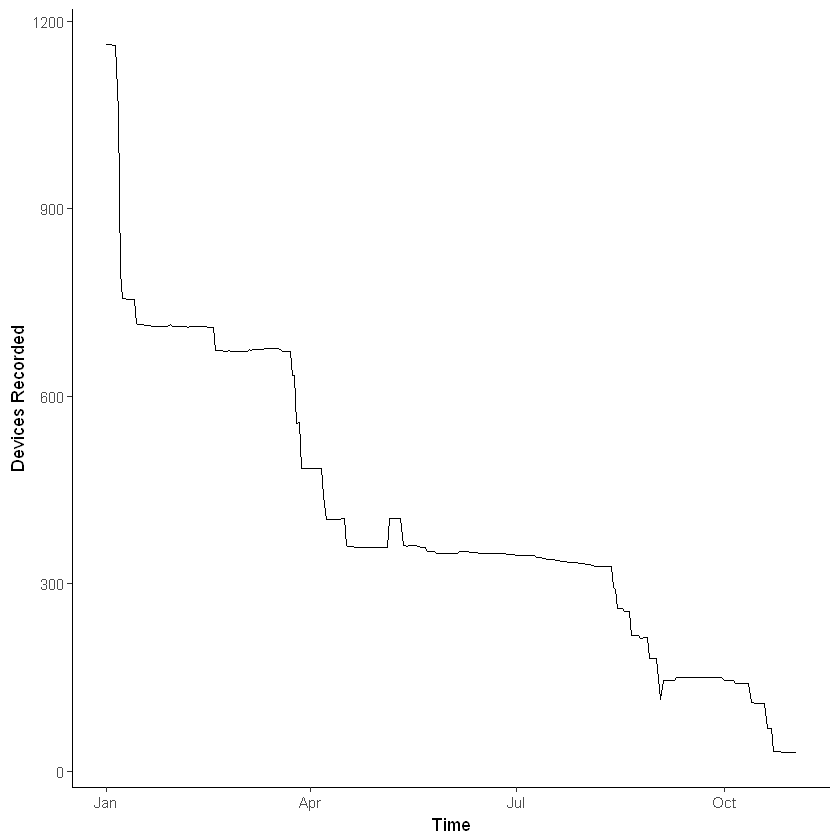

In [7]:
# Devices
print(paste0(length(unique(df$device)), ' unique devices')) #1168 unique devices

# Number of devices recorded each day.
countDeviceEachDay <- df %>% select(date) %>% count(date)
ggplot(countDeviceEachDay, aes(x=date)) + geom_line(aes(y=n)) + labs(x='Time', y='Devices Recorded')

There are 1168 devices. Since there a single device reading each day, the readings gradually decrease which can be observed from the above graph. It looks like the failed devices were taken off.

In [8]:
# Let's check the date range of all devices
countDeviceDateRange <- df %>% select(date, device) %>% group_by(device) %>% 
  mutate(maxDate = max(date)) %>% mutate(minDate = min(date)) %>%
  select(-date) %>% distinct() %>% mutate(runningDays = (ymd(maxDate) - ymd(minDate))[[1]]) %>%
  arrange(desc(runningDays))

head(countDeviceDateRange)

device,maxDate,minDate,runningDays
S1F0E9EP,2015-11-02,2015-01-01,305
S1F0EGMT,2015-11-02,2015-01-01,305
S1F0FGBQ,2015-11-02,2015-01-01,305
S1F0FP0C,2015-11-02,2015-01-01,305
S1F0GCED,2015-11-02,2015-01-01,305
S1F0GGPP,2015-11-02,2015-01-01,305


We notice from the above data, we notice that 31 devices are still up. So the number of failures must be close to the count of devices that were taken off, if not reintroduced again which doesn't seem to be the case.
But the number of failures {nrow(df[df$failure == 1,])} is just 106. We have to check what there is a huge mismatch.

In [9]:
# Let's check the above discrepancy
countDeviceRestarts <- df %>% select(date, device, failure) %>% group_by(device) %>% 
  mutate(maxDate = max(date)) %>%
  mutate(failureDate = if_else(failure == 1, date, NULL)) %>% select(-date) %>% distinct()

dupDevice <- countDeviceRestarts %>% select(device) %>% count() %>% filter(n > 1)

# At this point it looks clear that many devices were taken off without failure
countDeviceRestarts <- countDeviceRestarts %>%
  mutate(Status = if_else(is.na(failureDate), 'Terminated-Unknown', 
                          if_else(failureDate == maxDate, 'Terminated-Failure', 'Restarted')))
countDeviceRestarts[countDeviceRestarts$device %in% dupDevice$device & countDeviceRestarts$failure==0,'Status'] <- 'Duplicated'
countDeviceRestarts <- countDeviceRestarts[countDeviceRestarts$Status != 'Duplicated',]
countDeviceRestarts[countDeviceRestarts$maxDate == '2015-11-02', 'Status'] <- 'Still Monitored'

print("Newly assigned device status:")
unique(countDeviceRestarts$Status)
head(countDeviceRestarts)

[1] "Newly assigned device status:"


[1] "Terminated-Unknown" "Still Monitored"    "Terminated-Failure"
[4] "Restarted"

device,failure,maxDate,failureDate,Status
S1F01085,0,2015-01-06,NA,Terminated-Unknown
S1F0166B,0,2015-01-06,NA,Terminated-Unknown
S1F01E6Y,0,2015-02-17,NA,Terminated-Unknown
S1F01JE0,0,2015-01-06,NA,Terminated-Unknown
S1F01R2B,0,2015-08-24,NA,Terminated-Unknown
S1F01TD5,0,2015-01-06,NA,Terminated-Unknown


From the above it is clear that many devices were taken off even without a failure or not recorded. That explains the 106 failures vs 1168 devices. The above table is created and each device is labelled for status. Some devices were also restarted.
Since devices were also pulled off without failure, survival analysis will not be possible.
#### Below are the devices status frequency

Var1,Freq
Restarted,5
Still Monitored,31
Terminated-Failure,101
Terminated-Unknown,1031


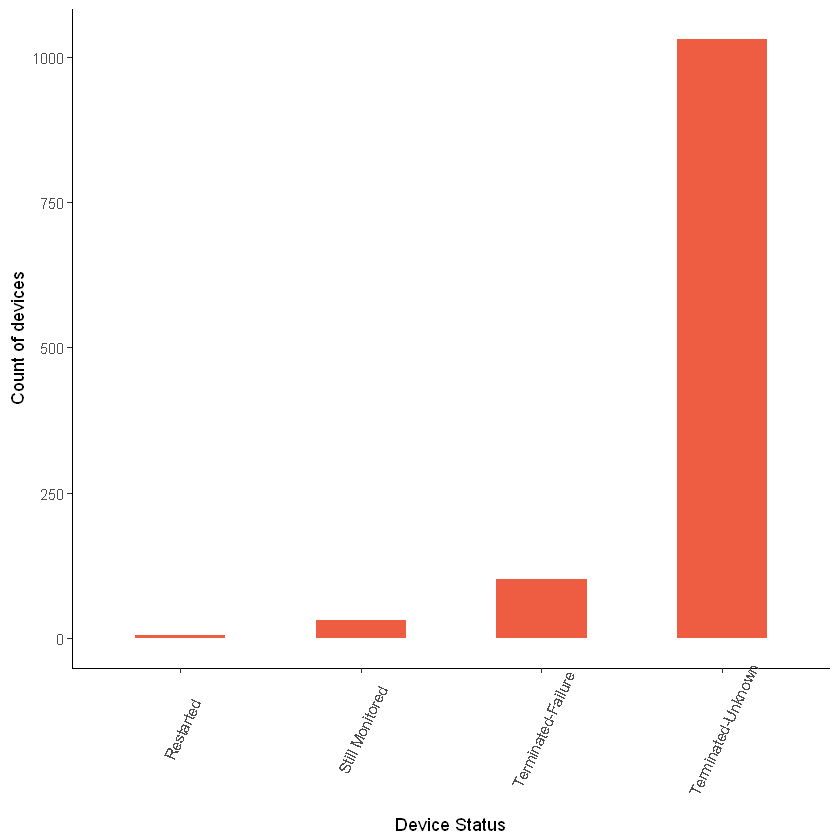

In [10]:
# Frequency table of device types
freqtable <- table(countDeviceRestarts$Status)
freqtable <- as.data.frame.table(freqtable)
freqtable

ggplot(freqtable, aes(Var1, Freq)) + geom_bar(stat="identity", width = 0.5, fill="tomato2") + 
  labs(x = "Device Status", y = "Count of devices") +
  theme(axis.text.x = element_text(angle=65, vjust=0.6))

In [11]:
# Check if there are more than 1 failures. No devices failed
countManyDeviceFailures <- df %>% select(device, failure) %>% filter(failure==1) %>%
  select(device) %>% group_by(device) %>% count() %>% filter(n > 1)
countManyDeviceFailures

# Devices which started late.
print('Devices which started late.')
countDeviceDateRange[countDeviceDateRange$minDate > '2015-01-01',]

device,n


[1] "Devices which started late."


device,maxDate,minDate,runningDays
W1F0976M,2015-10-12,2015-01-27,258
S1F013BB,2015-05-11,2015-05-06,5
S1F02W1L,2015-05-11,2015-05-06,5
S1F02XLX,2015-05-11,2015-05-06,5
S1F03499,2015-05-11,2015-05-06,5


From the above we can see no device has failed more than 1. But there are instances that the device was pulled off after re-introduction post failure.
Also, 5 devices started late i.e. post '2015-01-01'. Among them 4 devices were introduced together and pulled out together. The uptime for these devices are really low and cannot be attributed to cases of failure without appropriate target label.
#### Below we will see the categorized uptime of devices

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    2.0     5.0    85.0   111.6   225.0   305.0 

[1] 317

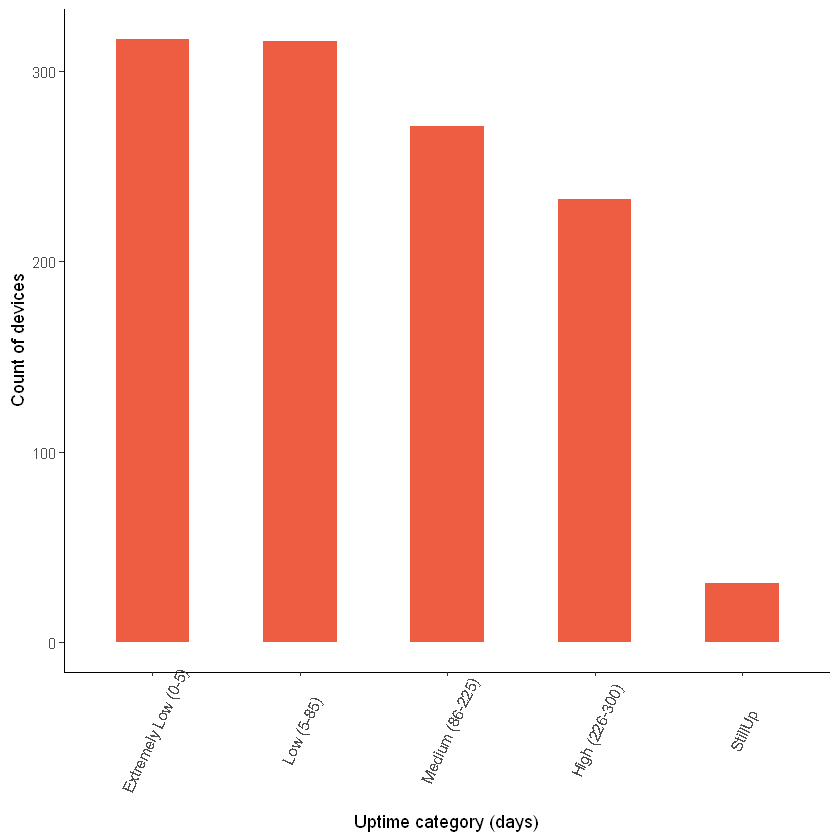

In [12]:
# Average uptime in days
summary(countDeviceDateRange$runningDays)
nrow(countDeviceDateRange[countDeviceDateRange$runningDays <= 5 ,])
countDeviceDateRange$uptime <- cut(countDeviceDateRange$runningDays, 
                                   breaks = c(-Inf, 5, 85, 225, 300, Inf), 
                                   labels = c("Extremely Low (0-5)","Low (5-85)","Medium (86-225)","High (226-300)", "StillUp"))

freqtable <- table(countDeviceDateRange$uptime)
freqtable <- as.data.frame.table(freqtable)

ggplot(freqtable, aes(Var1, Freq)) + geom_bar(stat="identity", width = 0.5, fill="tomato2") + 
  labs(x = "Uptime category (days)", y = "Count of devices") +
  theme(axis.text.x = element_text(angle=65, vjust=0.6))

Many devices had an extremely low and low uptime. This may affect forecasting device failures with runtime.
Telemetric readings will play an important factor.

#### Below are some patterns over time

maxDate,count,month,wday,week
2015-01-06,205,Jan,Tues,1
2015-01-05,106,Jan,Mon,1
2015-03-27,72,Mar,Fri,13
2015-03-25,64,Mar,Wed,12
2015-05-11,47,May,Mon,19
2015-04-06,42,Apr,Mon,14


Adding missing grouping variables: `maxDate`
Adding missing grouping variables: `maxDate`
Adding missing grouping variables: `maxDate`


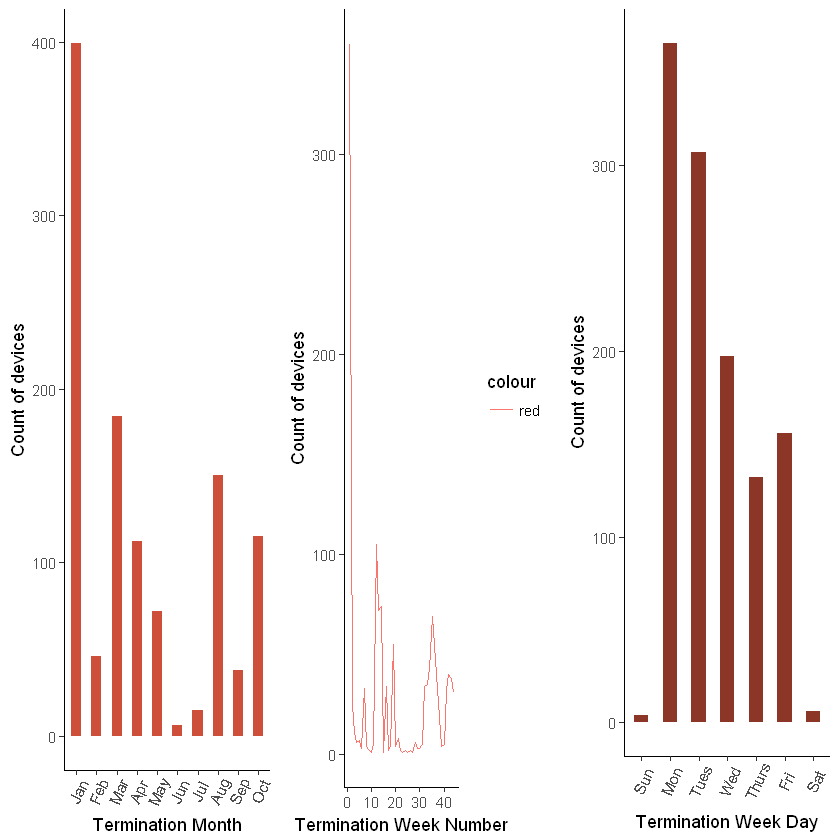

In [13]:
# Lets count start date and end date
countDeviceEndDate <- countDeviceDateRange %>% group_by(maxDate) %>% mutate(count = n()) %>% 
  select(maxDate, count) %>% distinct()
countDeviceStartDate <- countDeviceDateRange %>% group_by(minDate) %>% mutate(count = n()) %>% 
  select(minDate, count) %>% distinct()

# Lets analyze device termination days
countDeviceEndDate$month <- lubridate::month(countDeviceEndDate$maxDate, label = TRUE)
countDeviceEndDate$wday <- lubridate::wday(countDeviceEndDate$maxDate, label = TRUE)
countDeviceEndDate$week <- lubridate::week(countDeviceEndDate$maxDate)
countDeviceEndDate <- countDeviceEndDate %>% arrange(desc(count))
head(countDeviceEndDate)

# Count per month
countTermPerMonth <- countDeviceEndDate %>% select(month, count) %>% 
  group_by(month) %>% summarise(Terminations = sum(count))
g1 <- ggplot(countTermPerMonth[-nrow(countTermPerMonth),], aes(month, Terminations)) + 
  geom_bar(stat="identity", width = 0.5, fill="tomato3") + 
  labs(x = "Termination Month", y = "Count of devices") +
  theme(axis.text.x = element_text(angle=65, vjust=0.6))

# Count per week
countTermPerWeek <- countDeviceEndDate %>% select(week, count) %>% 
  group_by(week) %>% summarise(Terminations = sum(count))
g2 <- ggplot(countTermPerWeek, aes(x=week)) + geom_line(aes(y=Terminations, col='red')) + 
  labs(x='Termination Week Number', y='Count of devices')

# Count per week day
countTermPerWday <- countDeviceEndDate %>% select(wday, count) %>% 
  group_by(wday) %>% summarise(Terminations = sum(count))
g3 <- ggplot(countTermPerWday, aes(wday, Terminations)) + 
  geom_bar(stat="identity", width = 0.5, fill="tomato4") + 
  labs(x = "Termination Week Day", y = "Count of devices") +
  theme(axis.text.x = element_text(angle=65, vjust=0.6))

grid.arrange(g1, g2, g3, nrow = 1, ncol = 3)

The above graph shows terminations per month, week number and week day. January had a lot of terminations either due to 
failure or pull off. Mondays and Tuesdays have witnessed higher terminations. We will see further if these adds any value 
to the model.
#### We will now analyze the telemetric attribute readings.

,Var1,Var2,Freq
70,attribute7,attribute8,1.0
75,attribute3,attribute9,0.5
29,attribute2,attribute4,0.1


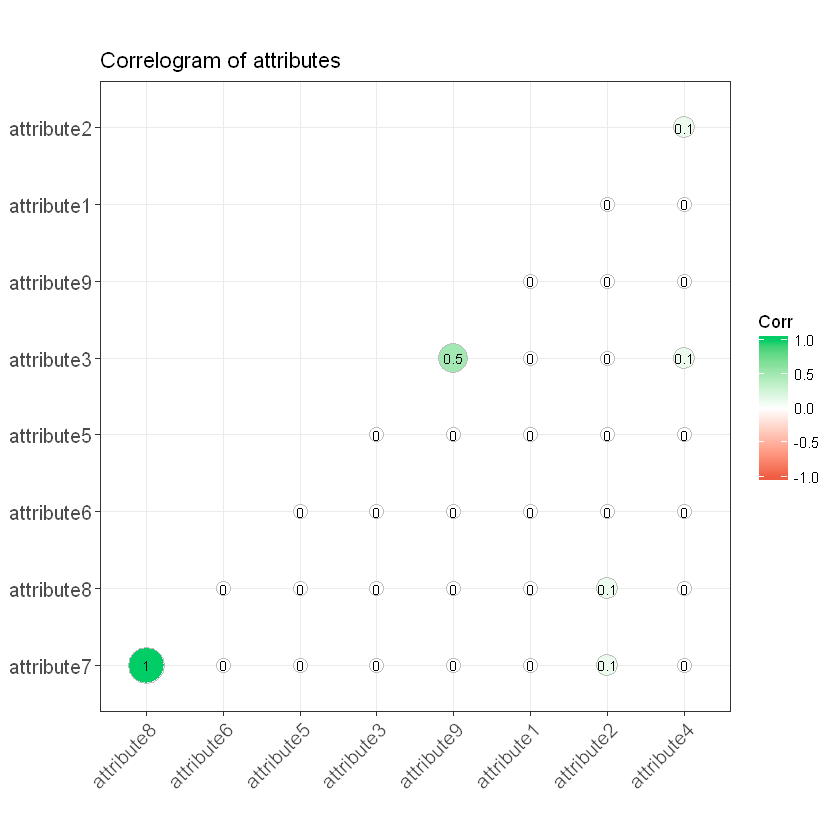

In [14]:
# Correlation between attributes
corMatrix <- cor(df[,6:14])
corMatrix <- round(cor(df[,6:14]), 1)

# Plot
ggcorrplot(corMatrix, hc.order = TRUE, 
           type = "lower", 
           lab = TRUE, 
           lab_size = 3, 
           method="circle", 
           colors = c("tomato2", "white", "springgreen3"), 
           title="Correlogram of attributes", 
           ggtheme=theme_bw)

# Attribute 7 and 8 are correlated
corMatrix[lower.tri(corMatrix,diag=TRUE)]=NA
corMatrix=as.data.frame(as.table(corMatrix))
corMatrix=na.omit(corMatrix)
corMatrix=corMatrix[order(-abs(corMatrix$Freq)),]
corMatrix[1:3,]

Attribute7 and attribute are the same. We must remove one of them while modelling.
#### Below are the density plots of the attributes

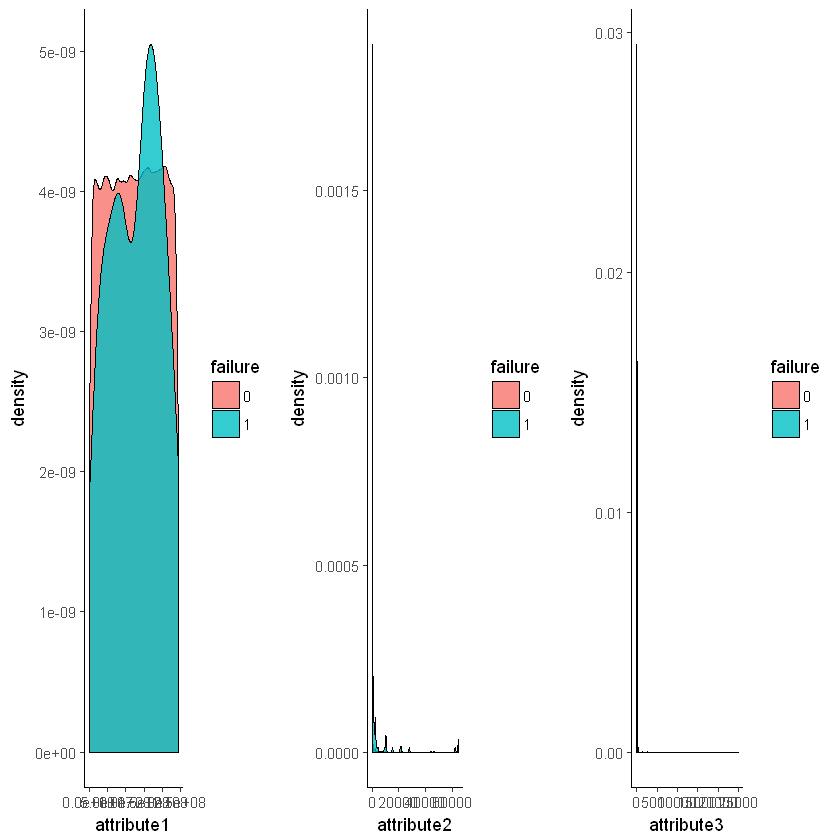

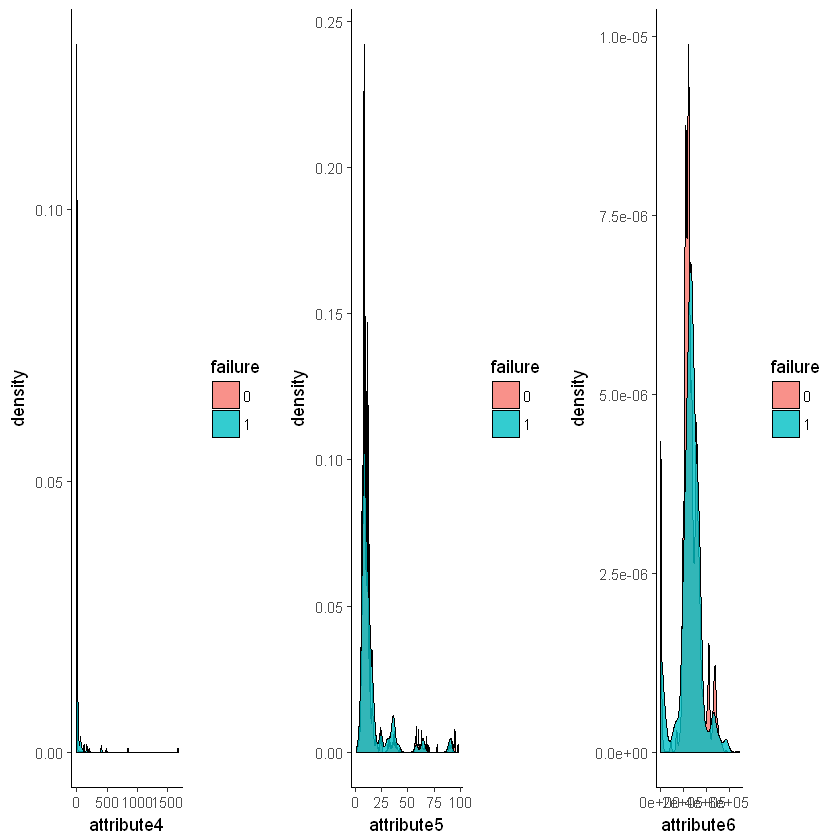

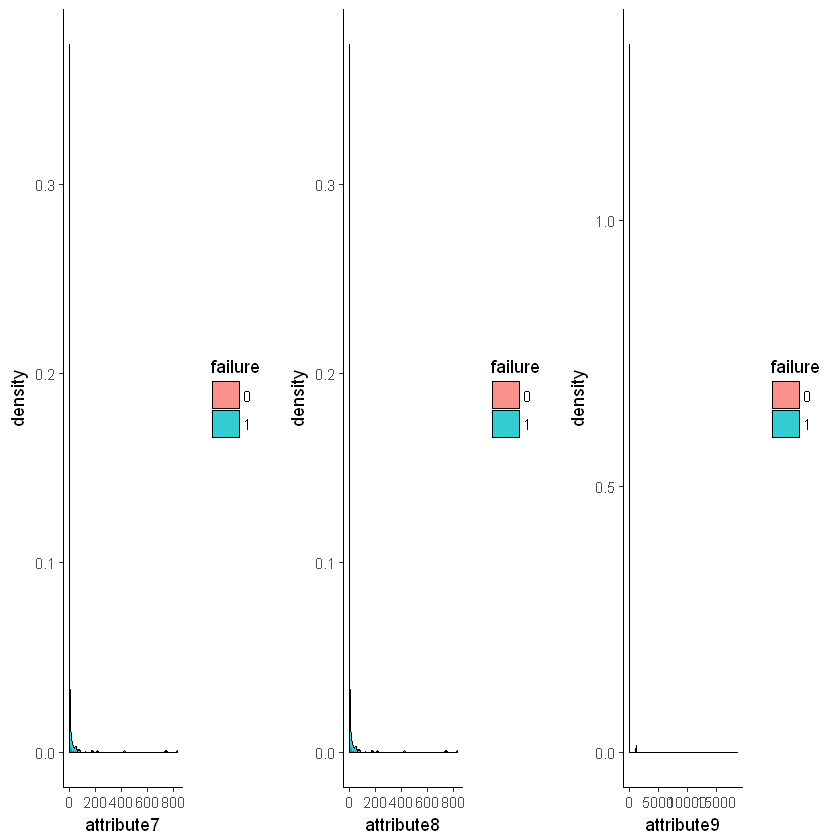

In [15]:
# Plot density
g1 <- ggplot(df, aes(attribute1)) + geom_density(aes(fill=failure), alpha=0.8)
g2 <- ggplot(df, aes(attribute2)) + geom_density(aes(fill=failure), alpha=0.8) 
g3 <- ggplot(df, aes(attribute3)) + geom_density(aes(fill=failure), alpha=0.8) 
g4 <- ggplot(df, aes(attribute4)) + geom_density(aes(fill=failure), alpha=0.8) 
g5 <- ggplot(df, aes(attribute5)) + geom_density(aes(fill=failure), alpha=0.8) 
g6 <- ggplot(df, aes(attribute6)) + geom_density(aes(fill=failure), alpha=0.8) 
g7 <- ggplot(df, aes(attribute7)) + geom_density(aes(fill=failure), alpha=0.8) 
g8 <- ggplot(df, aes(attribute8)) + geom_density(aes(fill=failure), alpha=0.8) 
g9 <- ggplot(df, aes(attribute9)) + geom_density(aes(fill=failure), alpha=0.8) 

grid.arrange(g1, g2, g3, nrow = 1, ncol = 3)
grid.arrange(g4, g5, g6, nrow = 1, ncol = 3)
grid.arrange(g7, g8, g9, nrow = 1, ncol = 3)

# Analyze near zero variance columns
#print('Near Zero Variance columns')
#nearZeroVar(df[,-ncol(df)], names = TRUE)

Attribute 1 and 6 are non-sparse, other attributes are highly left skewed. Sparcity is really high among them.
#### Near Zero Variance Columns
##### nearZeroVar(df[,-ncol(df)], names = TRUE)
'attribute2' 'attribute3' 'attribute4' 'attribute7' 'attribute8' are identified as nzv columns. Since they are mostly sparse and very few unique values, they might indicate some level readings. Rolling means may not work here.
#### Summarizing attributes below

In [16]:
print('attribute summary for failures.')
summary(df[df$failure==1,6:14])

print('attribute summary for non-failures.')
summary(df[df$failure==0,6:14])

[1] "attribute summary for failures."


   attribute1          attribute2      attribute3        attribute4     
 Min.   :  4527376   Min.   :    0   Min.   :  0.000   Min.   :   0.00  
 1st Qu.: 70462350   1st Qu.:    0   1st Qu.:  0.000   1st Qu.:   0.00  
 Median :139117254   Median :    0   Median :  0.000   Median :   1.50  
 Mean   :127175527   Mean   : 4109   Mean   :  3.906   Mean   :  54.63  
 3rd Qu.:183706600   3rd Qu.: 1182   3rd Qu.:  0.000   3rd Qu.:  18.75  
 Max.   :243261216   Max.   :64784   Max.   :318.000   Max.   :1666.00  
   attribute5      attribute6       attribute7       attribute8    
 Min.   : 3.00   Min.   :    24   Min.   :  0.00   Min.   :  0.00  
 1st Qu.: 8.00   1st Qu.:230029   1st Qu.:  0.00   1st Qu.:  0.00  
 Median :10.00   Median :267649   Median :  0.00   Median :  0.00  
 Mean   :15.46   Mean   :258304   Mean   : 30.62   Mean   : 30.62  
 3rd Qu.:14.00   3rd Qu.:309156   3rd Qu.: 16.00   3rd Qu.: 16.00  
 Max.   :91.00   Max.   :574599   Max.   :832.00   Max.   :832.00  
   attribute9

[1] "attribute summary for non-failures."


   attribute1          attribute2        attribute3          attribute4      
 Min.   :        0   Min.   :    0.0   Min.   :    0.000   Min.   :   0.000  
 1st Qu.: 61265844   1st Qu.:    0.0   1st Qu.:    0.000   1st Qu.:   0.000  
 Median :122785512   Median :    0.0   Median :    0.000   Median :   0.000  
 Mean   :122382672   Mean   :  156.1   Mean   :    9.946   Mean   :   1.696  
 3rd Qu.:183306934   3rd Qu.:    0.0   3rd Qu.:    0.000   3rd Qu.:   0.000  
 Max.   :244140480   Max.   :64968.0   Max.   :24929.000   Max.   :1666.000  
   attribute5      attribute6       attribute7         attribute8      
 Min.   : 1.00   Min.   :     8   Min.   :  0.0000   Min.   :  0.0000  
 1st Qu.: 8.00   1st Qu.:221452   1st Qu.:  0.0000   1st Qu.:  0.0000  
 Median :10.00   Median :249794   Median :  0.0000   Median :  0.0000  
 Mean   :14.22   Mean   :260175   Mean   :  0.2667   Mean   :  0.2667  
 3rd Qu.:12.00   3rd Qu.:310266   3rd Qu.:  0.0000   3rd Qu.:  0.0000  
 Max.   :98.00   Max. 

We notice that the mean changes a lot for failures and non-failures. Maybe we can use rolling mean for modelling.
#### We will not remove outliers!!! Since the attribute outlier values can indicate outcomes.
Below we will analyze any patterns right before a failure.

[1] "Displaying attribute patterns for failed devices..."


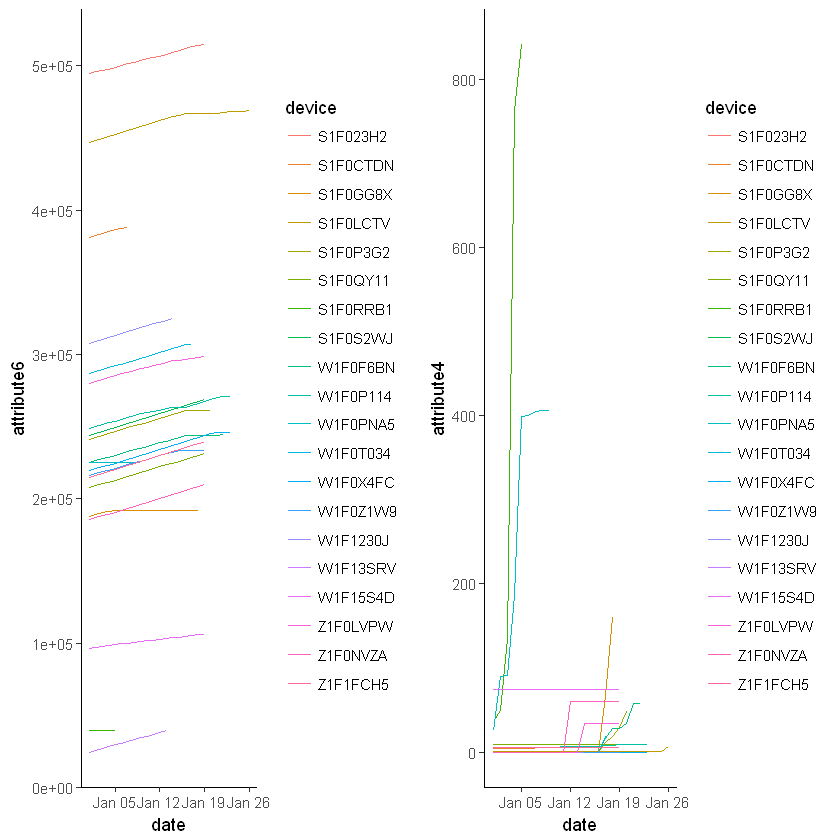

In [17]:
# Attribute pattern before failure
failedDevs <- countDeviceRestarts[countDeviceRestarts$Status == 'Terminated-Failure' ,'device']
attDeviceFailure <- df %>% filter(device %in% failedDevs$device[1:20]) %>% arrange(device, date)
g1 <- ggplot(attDeviceFailure, aes(x=date)) + geom_line(aes(y=attribute6, col=device))
g2 <- ggplot(attDeviceFailure, aes(x=date)) + geom_line(aes(y=attribute4, col=device))
print('Displaying attribute patterns for failed devices...')
grid.arrange(g1, g2, nrow = 1)

[1] "Displaying attribute patterns for non-failed devices..."


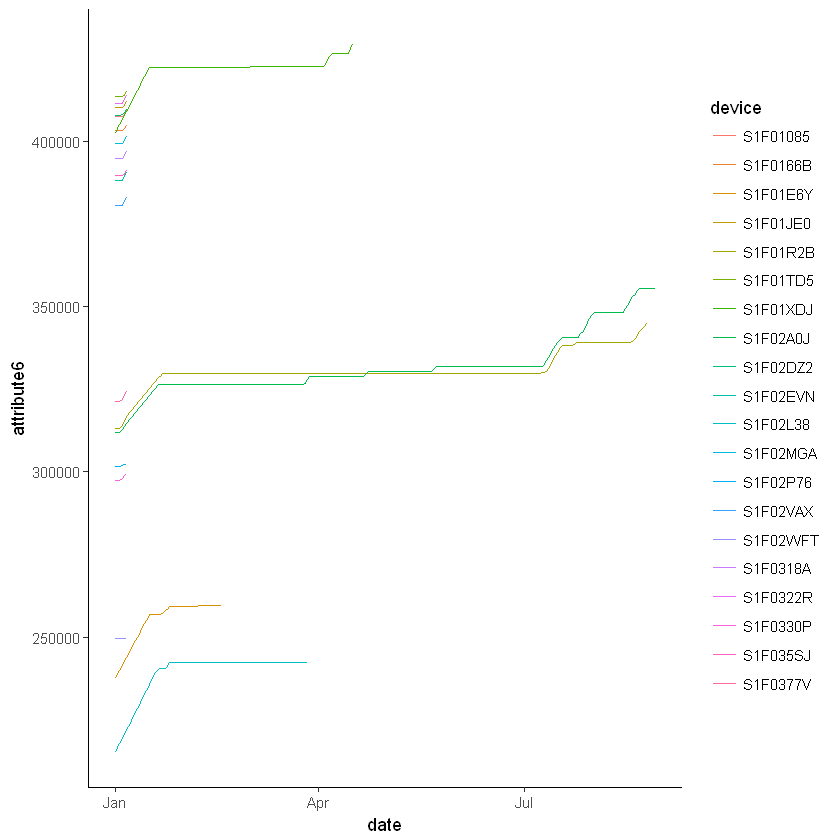

In [18]:
# We can notice attribute 6 increases till failure. Is this true for non failure?
nonfailedDevs <- countDeviceRestarts[countDeviceRestarts$Status == 'Terminated-Unknown' ,'device']
attDevicenonFailure <- df %>% filter(device %in% nonfailedDevs$device[1:20]) %>% arrange(device, date)
g1 <- ggplot(attDevicenonFailure, aes(x=date)) + geom_line(aes(y=attribute6, col=device))
print('Displaying attribute patterns for non-failed devices...')
grid.arrange(g1, nrow = 1)
# Not that much. We may say that increase in attribute 6 may lead to a failure

From the above two plots we see a pattern for a pattern for attribute 6 which steadily increases till a failure occurs. This pattern is not much observed for non-failure cases. Attribute 6 might be a good indicator for failures.

#### We will next check if there is a device type pattern for failures using device id

[1] "S1F0" "S1F1" "W1F0" "W1F1" "Z1F0" "Z1F1" "Z1F2"


      S1F0       S1F1       W1F0       W1F1       Z1F0       Z1F1 
0.33962264 0.05660377 0.25471698 0.14150943 0.12264151 0.08490566 

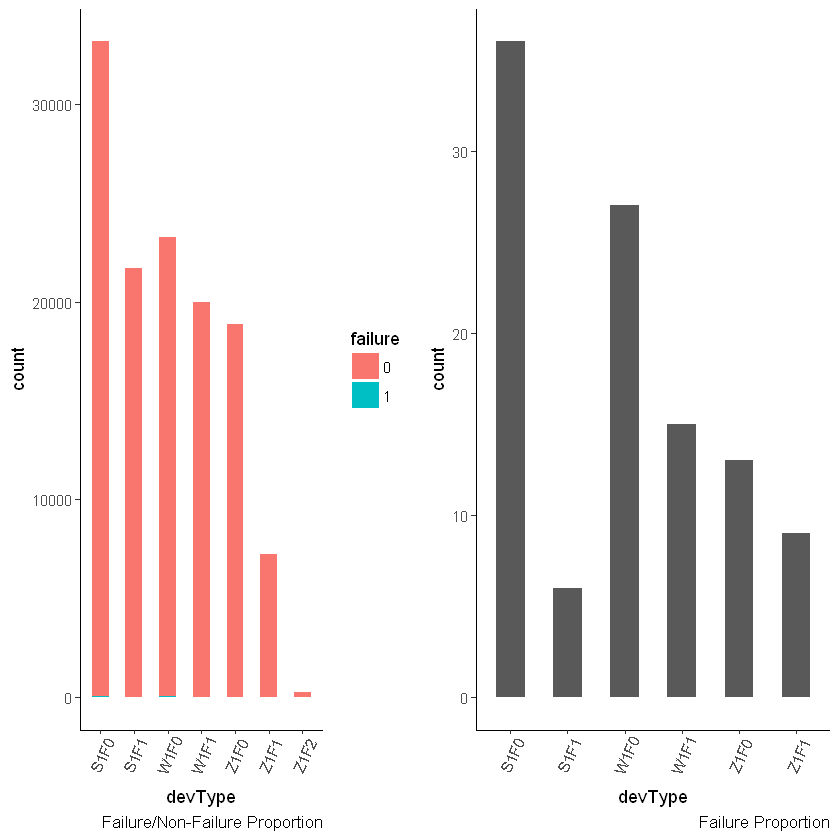

In [19]:
# Device type analysis
df$devType <- substr(df$device,1,4)
unique(df$devType)
g1 <- ggplot(df, aes(devType)) + geom_bar(aes(fill=failure), width = 0.5) + 
  labs(caption='Failure/Non-Failure Proportion') + theme(axis.text.x = element_text(angle=65, vjust=0.6))
g2 <- ggplot(df[df$failure==1,], aes(devType)) + geom_bar(width = 0.5) + labs(caption='Failure Proportion') + 
theme(axis.text.x = element_text(angle=65, vjust=0.6))
grid.arrange(g1,g2, nrow = 1)

# devices that have failed
prop.table(table(df[df$failure==1,'devType']))

From the above plot we notice failures are high for few categories. We will now start modelling.

### 3. Data Preparation
We will prepare the data prior to modelling. We will check class balance and create extra features like rolling mean from attributes to help the model.

In [20]:
# Class balance
prop.table(table(df$failure))
# Class is highly imbalanced


           0            1 
0.9991485533 0.0008514467 

The classes are highly imbalanced. We will need to oversample the minority class at some point. To start with we will remove devices from dataset with extremely low uptime as they most likely do not indicate anything especially not failure.

In [21]:
df$week <- as.integer(as.character(df$week))
lowrundevices <- countDeviceDateRange %>% filter(runningDays > 5)
df <- df %>% filter(device %in% lowrundevices$device)

We will create extra features with attributes using rolling means and rolling sd. Attribute 1 and 6 are dense and rolling may be able to capture trends. Other option is random walk with drift but we will not do it. Rolling means willbe of short window duration. Rolling sd may be helpful as the columns 1 and 6 have high variances.

In [22]:
# Rolling mean
df <- df %>%
  group_by(device) %>%
  arrange(device, date) %>%
  mutate(rollmean_s_att1 = rollmean(x = attribute1, 5, align = "right", fill = 0),
         rollmean_s_att6 = rollmean(x = attribute6, 5, align = "right", fill = 0))


# Roll sd
df <- df %>%
  group_by(device) %>%
  arrange(device, date) %>%
  mutate(roll_sd_att1 = rollapply(attribute1, width = 5, FUN = sd, fill = 0, align = 'r'),
         roll_sd_att6 = rollapply(attribute6, width = 5, FUN = sd, fill = 0, align = 'r'))

### 4. Modelling
We will start modelling.

In [ ]:
# Select relevant columns
df <- df %>% select(-c(date, device, month, wday, devType, attribute7)) 
df <- df[,-1]
df <- df[,c(names(df)[!names(df) %in% 'failure'], 'failure')]
levels(df$failure) <- c("class0", "class1")

# Stratefied Sampling
inTrain <- createDataPartition(y = df$failure, list = FALSE, p = .8)
train <- df[inTrain,]
test <- df[-inTrain,]
stopifnot(nrow(train) + nrow(test) == nrow(df))
stopifnot(levels(test$failure) > 1)

Relevant columns were selected and stratefied sampling is performed.

#### AutoML using h2o.ai
AutoML is a good starting point to identify the type of model we are looking for. Intuition is a tree based model would
work best for this scenario.

#### Synthetic sampling
Although boosted trees in AutoML might take care of class imbalance, but this situation is severe. Also, till date autoML does not allow to manually control class imbalance. Hence, we will use SMOTE to oversample minority class.

In [ ]:
# Use all cores -1 
h2o.init(nthreads = -1)

In [25]:
y <- "failure"
x <- setdiff(names(train), y)

# Smote sampling
train_smote <- SMOTE(failure ~ ., as.data.frame(train), perc.over = 30000)
prop.table(table(train_smote$failure))


   class0    class1 
0.6659267 0.3340733 

The above classes looks much more balanced. Now we will train autoML for not more than 15 mins to get a glimpse of 
model performances as a starting point.
##### Metric: AUC
Since we need to reduce FP/FN, AUC-ROC curve will be the appropriate metric.

In [26]:
aml <- h2o.automl(x = x, y = y,
                  training_frame = as.h2o(train_smote),
                  leaderboard_frame = as.h2o(test),
                  stopping_metric = 'AUC',
                  max_runtime_secs = 900,
                  seed = seedVal)
aml@leaderboard

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


                                               model_id      auc  logloss
1             GBM_grid_0_AutoML_20180301_080906_model_6 0.952580 0.046784
2 StackedEnsemble_BestOfFamily_0_AutoML_20180301_080906 0.942014 0.008228
3             GBM_grid_0_AutoML_20180301_080906_model_4 0.937236 0.045977
4    StackedEnsemble_AllModels_0_AutoML_20180301_080906 0.927385 0.007933
5             GBM_grid_0_AutoML_20180301_080906_model_3 0.926154 0.045097
6             GBM_grid_0_AutoML_20180301_080906_model_1 0.910579 0.057839

[16 rows x 3 columns] 

In [27]:
# Shutdown h2o
#h2o.shutdown(prompt=FALSE)

[1] TRUE

autoML indicates GBM will be a good model. We can further use GBM with grid tuning to improve the model. autoML as not tested on test data but validation frame is fairly accurate. But we need to see if we are overfitting test data or not. We will do that using GBM and the caret package.

#### Gradient Boosting
We will do GBM using caret library via caret and minority class will be oversampled using smote. Below are the grid parameters.

### 5. Model Tuning and Evaluation

In [28]:
# Grid Tuning
#registerDoMC(cores = 4)

# Max shrinkage for gbm
nl = nrow(train)
print(paste0('Optimum shrinkage param = ', max(0.01, 0.1*min(1, nl/10000))))

# Max Value for interaction.depth
print(paste0('Optimum interaction depth = ', floor(sqrt(NCOL(train)))))

gbmGrid <- expand.grid(interaction.depth = c(1, 3, 6),
                        n.trees = (0:50)*5, 
                        shrinkage = c(.1, .05,.025),
                        n.minobsinnode = c(5, 10, 15, 20))

[1] "Optimum shrinkage param = 0.1"
[1] "Optimum interaction depth = 3"


Grid Tune is computationally expensive and I have turned this off at this point. We will train with pre-executed weights.

In [ ]:
# Fit gbm
trctrl <- trainControl(method = "repeatedcv", 
                       number = 3, 
                       repeats = 2, 
                       verboseIter = FALSE,
                       classProbs = TRUE,
                       summaryFunction = twoClassSummary,
                       sampling = "smote")

model.gbm <- caret::train(failure ~ . 
                          , data = train
                          , method = "gbm"
                          , metric = "ROC"
                          , preProcess = c("scale", "center")
                          , na.action = na.omit
                          #, tuneGrid = gbmGrid
                          , trControl = trctrl)

gbm variable importance

                Overall
attribute4       87.646
attribute8       82.246
attribute2       73.621
rollmean_s_att6  16.493
week             13.833
rollmean_s_att1  11.188
roll_sd_att6      7.715
attribute1        3.497
attribute6        2.430
attribute9        2.322
attribute5        1.877
attribute3        1.479
roll_sd_att1      1.181

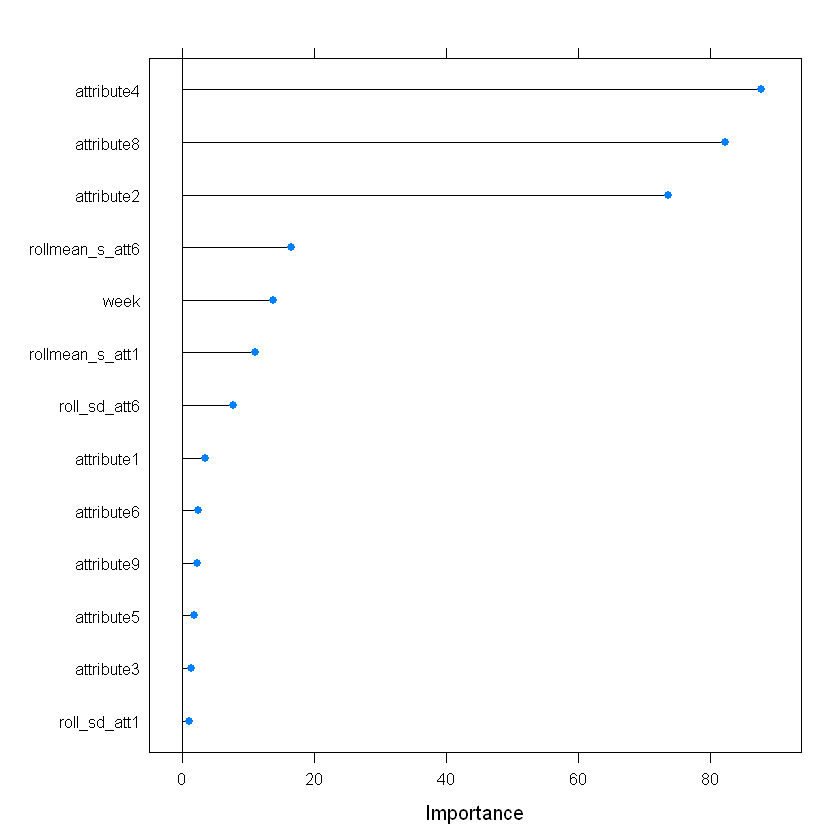

In [44]:
# Plot variable importance
gbmImp <- varImp(model.gbm, scale = FALSE)
gbmImp
plot(gbmImp)

The variable importance is plotted above. As expected, the rolling mean and standard deviation was helpful. There were few surprises. Device type and weekday did not help the model, so it was removed. However, we notice week number is a good predictor.

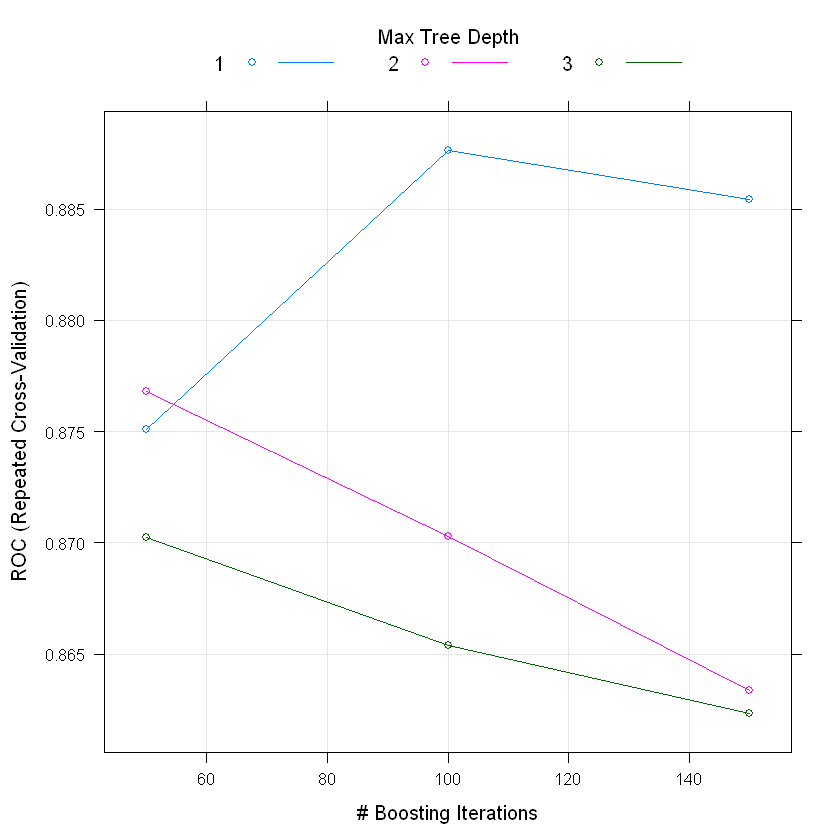

In [45]:
# Plotting the model.
plot(model.gbm)

We notice the ROC slightly reduces with the number of boosting iterations. It happens when the data is noisy and in our case this might be a good reason. Since boosting focusses on miscalssifications, it may bring out the average performance. It is more important that we check if we are overfitting the data or not. We will check ROC using test data and at 0.5 cutoff. 

In [34]:
# Predict test data
pred <- predict(model.gbm, test[,-ncol(test)], type = "raw")
predicted <- ifelse(pred == 'class0', 0, 1)

# score prediction using AUC
reference <- ifelse(test$failure == 'class0', 0, 1)
auc <- roc(reference, predicted)
print(auc)
confusionMatrix(reference = reference, data = predicted)


Call:
roc.default(response = reference, predictor = predicted)

Data: predicted in 24519 controls (reference 0) < 21 cases (reference 1).
Area under the curve: 0.858


Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 23392     5
         1  1127    16
                                          
               Accuracy : 0.9539          
                 95% CI : (0.9512, 0.9565)
    No Information Rate : 0.9991          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.0259          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.9540          
            Specificity : 0.7619          
         Pos Pred Value : 0.9998          
         Neg Pred Value : 0.0140          
             Prevalence : 0.9991          
         Detection Rate : 0.9532          
   Detection Prevalence : 0.9534          
      Balanced Accuracy : 0.8580          
                                          
       'Positive' Class : 0               
                                          

In [48]:
# Below is a great plot for confusion matrix. It was referred from the below link
# https://stackoverflow.com/questions/23891140/r-how-to-visualize-confusion-matrix-using-the-caret-package; and credits to the SO user Cybernetic

draw_confusion_matrix <- function(cm) {

  layout(matrix(c(1,1,2)))
  par(mar=c(2,2,2,2))
  plot(c(100, 345), c(300, 450), type = "n", xlab="", ylab="", xaxt='n', yaxt='n')
  title('CONFUSION MATRIX', cex.main=2)

  # create the matrix 
  rect(150, 430, 240, 370, col='#3F97D0')
  text(195, 435, 'Class0', cex=1.2)
  rect(250, 430, 340, 370, col='#F7AD50')
  text(295, 435, 'Class1', cex=1.2)
  text(125, 370, 'Predicted', cex=1.3, srt=90, font=2)
  text(245, 450, 'Actual', cex=1.3, font=2)
  rect(150, 305, 240, 365, col='#F7AD50')
  rect(250, 305, 340, 365, col='#3F97D0')
  text(140, 400, 'Class0', cex=1.2, srt=90)
  text(140, 335, 'Class1', cex=1.2, srt=90)

  # add in the cm results 
  res <- as.numeric(cm$table)
  text(195, 400, res[1], cex=1.6, font=2, col='white')
  text(195, 335, res[2], cex=1.6, font=2, col='white')
  text(295, 400, res[3], cex=1.6, font=2, col='white')
  text(295, 335, res[4], cex=1.6, font=2, col='white')

  # add in the specifics 
  plot(c(100, 0), c(100, 0), type = "n", xlab="", ylab="", main = "DETAILS", xaxt='n', yaxt='n')
  text(10, 85, names(cm$byClass[1]), cex=1.2, font=2)
  text(10, 70, round(as.numeric(cm$byClass[1]), 3), cex=1.2)
  text(30, 85, names(cm$byClass[2]), cex=1.2, font=2)
  text(30, 70, round(as.numeric(cm$byClass[2]), 3), cex=1.2)
  text(50, 85, names(cm$byClass[5]), cex=1.2, font=2)
  text(50, 70, round(as.numeric(cm$byClass[5]), 3), cex=1.2)
  text(70, 85, names(cm$byClass[6]), cex=1.2, font=2)
  text(70, 70, round(as.numeric(cm$byClass[6]), 3), cex=1.2)
  text(90, 85, names(cm$byClass[7]), cex=1.2, font=2)
  text(90, 70, round(as.numeric(cm$byClass[7]), 3), cex=1.2)

  # add in the accuracy information 
  text(30, 35, names(cm$overall[1]), cex=1.5, font=2)
  text(30, 20, round(as.numeric(cm$overall[1]), 3), cex=1.4)
  text(70, 35, names(cm$overall[2]), cex=1.5, font=2)
  text(70, 20, round(as.numeric(cm$overall[2]), 3), cex=1.4)
} 

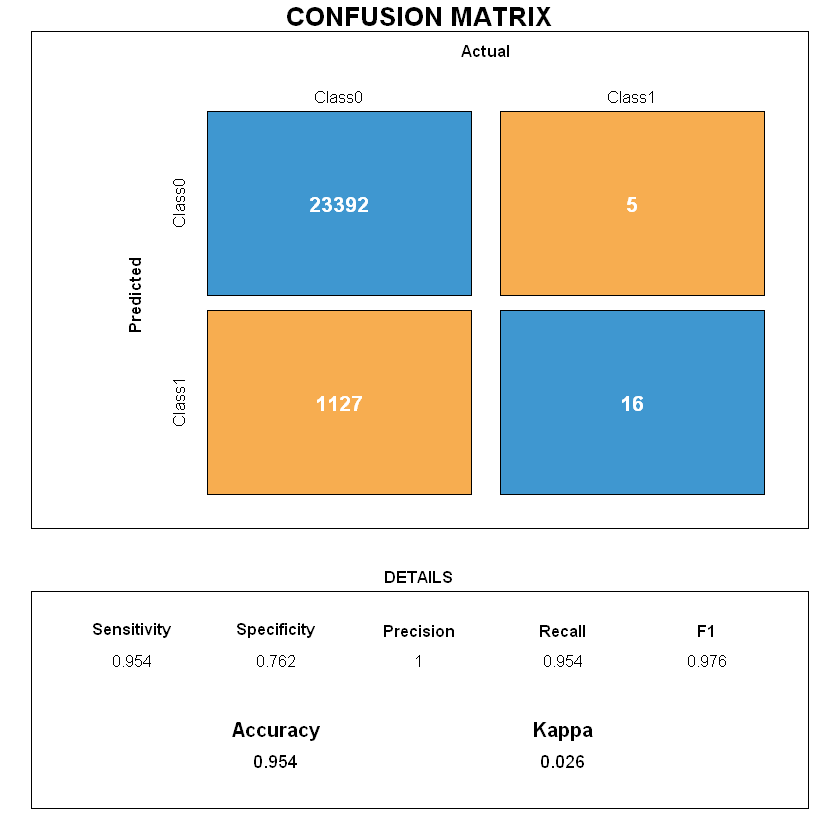

In [49]:
cm <- confusionMatrix(reference = reference, data = predicted)
draw_confusion_matrix(cm)

#### The model performance on test data is 0.858 AUC
We notice that the model predicted well and did not overfit. False positives and negatives are less which is a good thing.

### 6. Conclusions
#### How can we improve the model?
##### 1. Account for the device drop-outs due to non-failure. It will be unfair to assume what happened with these devices. If we are able to assign a label the devices, it will definitely help the model. Data prepared from relabelling will be helpful for survival analysis.
##### 2. Create more extra features from the attributes. We can try to create many more features such as lag, drift, random walk, differencing and check how it impacts the model. Markov Chains seems to work great with random values.
##### 3. Model it using time series. Sequence modelling like LSTM might work great to forecast failures but the data may not be enough.
##### 4. Anomaly detection. This could also be modelled in an unsupervised way.
##### 5. Grid tuning and ensemble learners. I wasn't able to perform thorough grid tuning due to limited resources of my personal machine. But we can try to grid tune using more parameters for better results and stack it using multiple learners.